<a href="https://colab.research.google.com/github/PabloDome/CosasUtilesDW/blob/main/ModeloPhi4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.2


<ipython-input-18-f7134e1f4083>:258: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "Imagen2" failed type inference due to: No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(readonly array(uint8, 3d, C), Tuple(int64, int64, Literal[int](0)), Literal[int](255))
 
There are 16 candidate implementations:
      - Of which 14 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(readonly array(uint8, 3d, C), UniTuple(int64 x 3), int64)':
       No match.
      - Of which 2 did not match due to:
      Overload in function 'SetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 176.
        With argument(s): '(readonly array(uint8, 3d, C), UniTuple(int64 x 3), int64)':
       Rejected as the implementation raised a specific error:
         NumbaTypeError: Cannot modify readonly array of type: readonly array(uint8, 

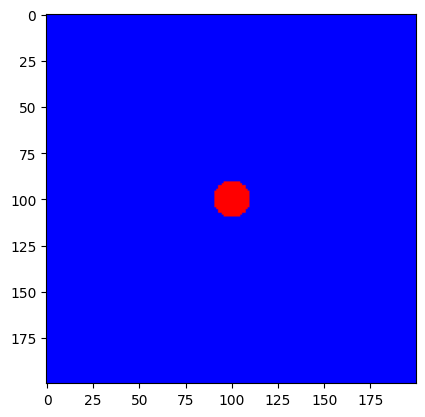

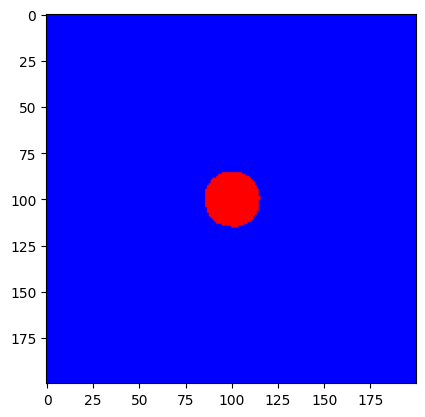

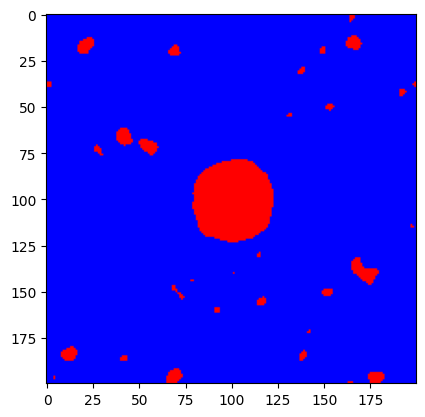

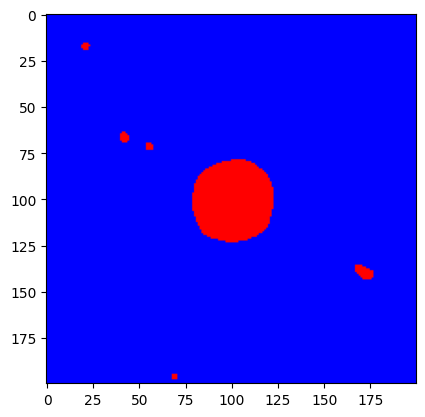

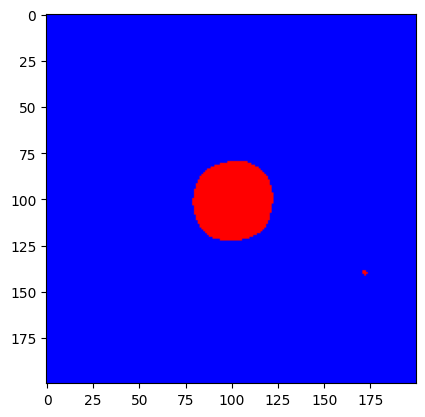

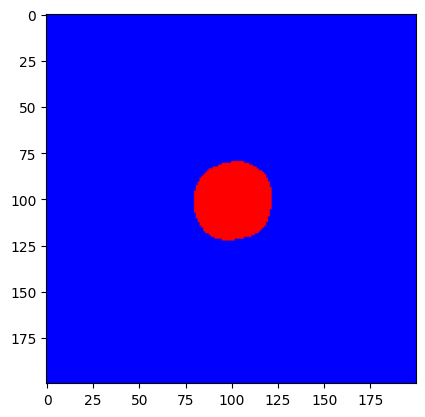

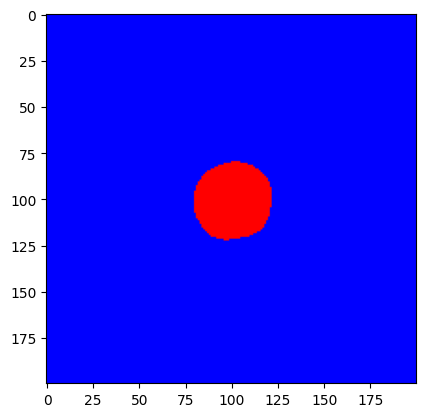

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numba import jit

# programa para hacer estudios en AC con pulsos cuadrados, hace barridos en campo
Mostrar_Imagen = 0 # Aparece una ventana externa donde se ve la figura de los dominios
Mostrar_Mag_Emerg = 0 # Aparece una ventana externa con la figura de la magnetizacion

# Datos del sistema
T = 0.0 # temperatura (ref = 0.01)
ampdis = 0.2 # Amplitud del desorden
N_ini = 1 # Desde que repeticion iniciar
N_Max = 1 # Repeticiones

SiDifMuestras = 1 # Crea muestras con diferentes patrones de desorden
e = 1.0 # sigma/delta = e (e va como A = 10 pJ/m = 10^{-11} J/m)
c = e # sigma*delta = c (c va como K = 1000 kJ/m3 = 10^6 J/m3)

Tam = 200 # Tamaño de la simulación - Tam = 300

#Detalles pared plana
ParedPlana = 0
L_plano = Tam/4

#Detalles circulos
RUnCirculo = 1 # Si pone o no un circulo
Rvarios = 0 # Si son varios circulos
Rd = 0
omega = 10
R_circ = 10 # Radio del circulo - Tam = 50
R_circ_CM_x = Tam*0.5 # Posición del circulo en x
R_circ_CM_y = Tam*0.5 # Posición del circulo en y


#Detalles capilar (si, me dio fiaca escribirlo bien)
MuestraPeine = 0 # Si vale 1 te arma los peines
Ancho_capilar = Tam/10
dL = 20
L = Tam - 4*dL
L1 = 0.05*L
L2 = 0.15*L
L3 = 0.3*L
L4 = 0.4*L
R_circ_CM_x1 = dL+0.5*L1
R_circ_CM_x2 = 2*dL+L1+0.5*L2
R_circ_CM_x3 = 3*dL+L1+L2+0.5*L3
R_circ_CM_x4 = 4*dL+L1+L2+L3+0.5*L4
Y_min = Tam*0.5-Ancho_capilar*0.5
Y_max = Tam*0.5+Ancho_capilar*0.5
X_min = 15
X_max = Tam-10

Tam_salida = 500 # Tamaño de la figura de la simulacion

H_DC = 0.4 # campo de crecimiento de los dominios (ref = 0.06)
T_DC = 100 # Cantidad de iteraciones donde se aplica H_DC

dN = 50 # Cada cuantas iteraciones toma una imagen
dt_0 = 0.01 # tiempo maximo de una iteración en la simulación
dt = 10*dt_0 # variación de tiempo, la maxima es dt = 0.1 después se pueden usar multiplos con dN
Period = 10*dt # Periodo para aplicar campo AC

N_Delta = 200 # Cantidad de iteraciones aplicando un campo AC
N_H0 = T_DC+N_Delta+1 # Número de iteraciones para campo nulo
N_H = T_DC+N_Delta+1 # Número de iteraciones para campos distintos a cero

h_ini = 0.2 # Campo inicial
h_fin = 0.2 # Campo final
h_paso = 0.05 # Campo paso
h = 0.0

# Defino los parametros iniciales
Des_mat = (np.random.random((Tam, Tam)))*2.0 - 1.0
phi = -1*(np.ones((Tam,Tam)))
Muestra = np.ones((Tam,Tam))
forcePhi=-1*(np.ones((Tam,Tam)))
phi_print = np.zeros((Tam,Tam,3), dtype=np.uint8)
phi_Grey = phi_print

# Defino funciones
@jit(nopython=True)
def SelectorPeine(j):
    if j<dL:
        return 0
    elif j<dL+L1 and j>dL:
        return 1
    elif j>dL+L1 and j<2*dL+L1:
        return 0
    elif j>2*dL+L1 and j<2*dL+L1+L2:
        return 1
    elif j>2*dL+L1+L2 and j<3*dL+L1+L2:
        return 0
    elif j>3*dL+L1+L2 and j<3*dL+L1+L2+L3:
        return 1
    elif j>3*dL+L1+L2+L3 and j<4*dL+L1+L2+L3:
        return 0
    elif j>4*dL+L1+L2+L3 and j<4*dL+L1+L2+L3+L4:
        return 1
    else:
        return 0

@jit
def DefinirMuestra():

    #Defino un peine
    if MuestraPeine == 1:
        for i in range(Tam):
            for j in range(Tam):

                Muestra[i,j] = SelectorPeine(j)

                if i < X_min or i > X_max:
                    Muestra[i,j] = 1

                if i == 0 or j ==0 or i == Tam-1 or j == Tam-1:
                    Muestra[i,j] = 0


@jit
def H_dep_tim(h_up, h_down, tim):

    fun = signo(np.sin(2*np.pi*tim*dt/Period))
    #fun = -1

    if (fun<=0):
        h = h_up
    else :
        h = -h_down

    return h

@jit(nopython=True)
def signo(numero):
    if numero > 0:
        return 1
    elif numero < 0:
        return -1
    else:
        return 0

@jit
def rellenar_huecos(imagen):
    # Copiar la imagen de entrada
    imagen_rellena = imagen.copy()

    # Encontrar contornos en la imagen
    contornos, _ = cv2.findContours(imagen_rellena, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Rellenar los contornos encontrados
    for contorno in contornos:
        cv2.drawContours(imagen_rellena, [contorno], 0, 255, -1)

    return imagen_rellena

@jit
def eliminar_particulas(imagen, tamano_minimo):
    # Encuentra los contornos en la imagen binarizada
    contornos, _ = cv2.findContours(imagen.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Elimina las partículas que tienen un área menor que el tamaño mínimo
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if area < tamano_minimo:
            cv2.drawContours(imagen, [contorno], 0, 0, -1)

    return imagen

def Calcangulo(x,y):
    theta = 0

    if (x>0) and (y>=0) :
        theta = np.arctan(y/x)
    elif x==0 and (y>0) :
        theta = np.pi/2
    elif x<0 :
        theta = np.arctan(y/x) + np.pi
    elif x==0 and (y<0) :
        theta = 3*np.pi/2
    elif x>0 and y<0 :
        theta = np.arctan(y/x) + 2*np.pi

    return theta

#Esto solo cambia valores a 1.0, por lo que si estan definidos en cero quedan asi
def selector(Val,i,j,R,Rx,Ry):

    x = (j-Rx)
    y = (i-Ry)

    if pow((i-Ry)*(i-Ry)+(j-Rx)*(j-Rx), 0.5)<R+Rd*np.sin(omega*Calcangulo(x,y)):
        return 1.0
    else:
        return Val

@jit
def ImagenParaPhi(Imagen):
    Imagen1 = 0*phi
    Imagen1 = cv2.resize(Imagen[:,:,0]/np.max(Imagen[:,:,0]),(Tam,Tam))

    for i in range(Tam):
        for j in range(Tam):
            if Imagen1[i,j]< 1:
                phi[i,j] = -1
            else:
                phi[i,j] = 1


#@jit(nopython=True)
def ini_matriz_circulos(phi):
    for i in range(Tam):
        for j in range(Tam):
            if Rvarios == 1:
                phi[i,j] = selector(phi[i,j],i,j,R_circ,R_circ_CM_x1,R_circ_CM_y)
                phi[i,j] = selector(phi[i,j],i,j,R_circ,R_circ_CM_x2,R_circ_CM_y)
                phi[i,j] = selector(phi[i,j],i,j,R_circ,R_circ_CM_x3,R_circ_CM_y)
                phi[i,j] = selector(phi[i,j],i,j,R_circ,R_circ_CM_x4,R_circ_CM_y)
            if RUnCirculo == 1:
                phi[i,j] = selector(phi[i,j],i,j,R_circ,R_circ_CM_x,R_circ_CM_y)

    phi = phi*Muestra
    return phi

@jit(nopython=True)
def ini_matriz_ParedPlana(phi):
    for i in range(Tam):
        for j in range(Tam):
            if i<L_plano:
                phi[i,j] = 1.0
    phi = phi*Muestra
    return phi

@jit(nopython=True)
def fuerza_elemento(phi, i, j, h, Des_mat):
    i_max = (i + 1)%Tam
    i_min = (i - 1 + Tam)%Tam
    j_max = (j + 1)%Tam
    j_min = (j - 1 + Tam)%Tam

    ev_phi = phi[i,j] + (c*(-4.0*phi[i,j] + phi[i_max,j] + phi[i_min,j] + phi[i,j_max] + phi[i,j_min]) + \
    e*(phi[i,j]*(1.0+ampdis*Des_mat[i,j]) - pow(phi[i,j], 3.0)) + h)*dt + \
    np.sqrt(T*dt/3.0)*np.random.uniform(-1, 1)

    return ev_phi

def euler_normal():
    i = 0
    while (i<Tam):
        j = 0
        while (j<Tam):
            if Muestra[i,j] == 1:
                phi[i,j] = fuerza_elemento(phi, i, j, h, Des_mat)
            elif Muestra[i,j] == 0:
                phi[i,j] = 0
            j += 1
        i += 1

@jit
def Imagen2(phi):
    for x in range(Tam):
        for y in range(Tam):
            if phi[x,y]>0:
                phi_print[x,y,0] = 255
                phi_print[x,y,1] = 0
                phi_print[x,y,2] = 0
            elif phi[x,y]<0:
                phi_print[x,y,0] = 0
                phi_print[x,y,1] = 0
                phi_print[x,y,2] = 255
            else:
                phi_print[x,y,0] = 0
                phi_print[x,y,1] = 0
                phi_print[x,y,2] = 0


# Inicio simulación
DefinirMuestra()

N = N_ini
while (N < N_Max+1):

    if SiDifMuestras == 1:
        Des_mat = (np.random.random((Tam, Tam)))*2.0 - 1.0

    H_externo = h_ini

    while H_externo < h_fin+h_paso :

        H_externo = float("{:.3f}".format(H_externo))

        print(H_externo)

        if H_externo == 0.0:
            N_t = N_H0
        else:
            N_t = N_H

        phi = phi*0-1

        if ParedPlana==1:
            phi = ini_matriz_ParedPlana(phi)
        else:
            phi = ini_matriz_circulos(phi)

        M = np.zeros((N_t,2))

        tim = 0

        while tim<N_t :

            if tim<T_DC :
                h = H_DC
            else:
                h = H_dep_tim(H_externo, H_externo, tim) # (amplitud h, h_up, h_down, tim)

            k = 0

            M[tim,0] = tim*dt
            M[tim,1] = np.mean(phi)

            if (tim%dN)==0 :

                Imagen2(phi)
                plt.imshow(phi_print)
                plt.show()

            euler_normal()

            tim = tim + 1

        H_externo += h_paso

    N += 1
